C:\Users\mnnia\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.1005 - val_loss: 6.1793e-04
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 4.8432e-04 - val_loss: 2.1545e-04
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.9959e-04 - val_loss: 1.3177e-04
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.3570e-04 - val_loss: 6.8910e-05
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 9.7249e-05 - val_loss: 1.6791e-04
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 7.6504e-05 - val_loss: 9.5314e-05
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 7.1152e-05 - val_loss: 4.4615e-05
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.5169e-05 - val_loss: 4.2346e-05
Epoch 9/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 4.8758e-05 - val_loss: 8.7851e-05
Epoch 10/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.5924e-05 - val_loss: 9.5482e-05
Epoch 11/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━

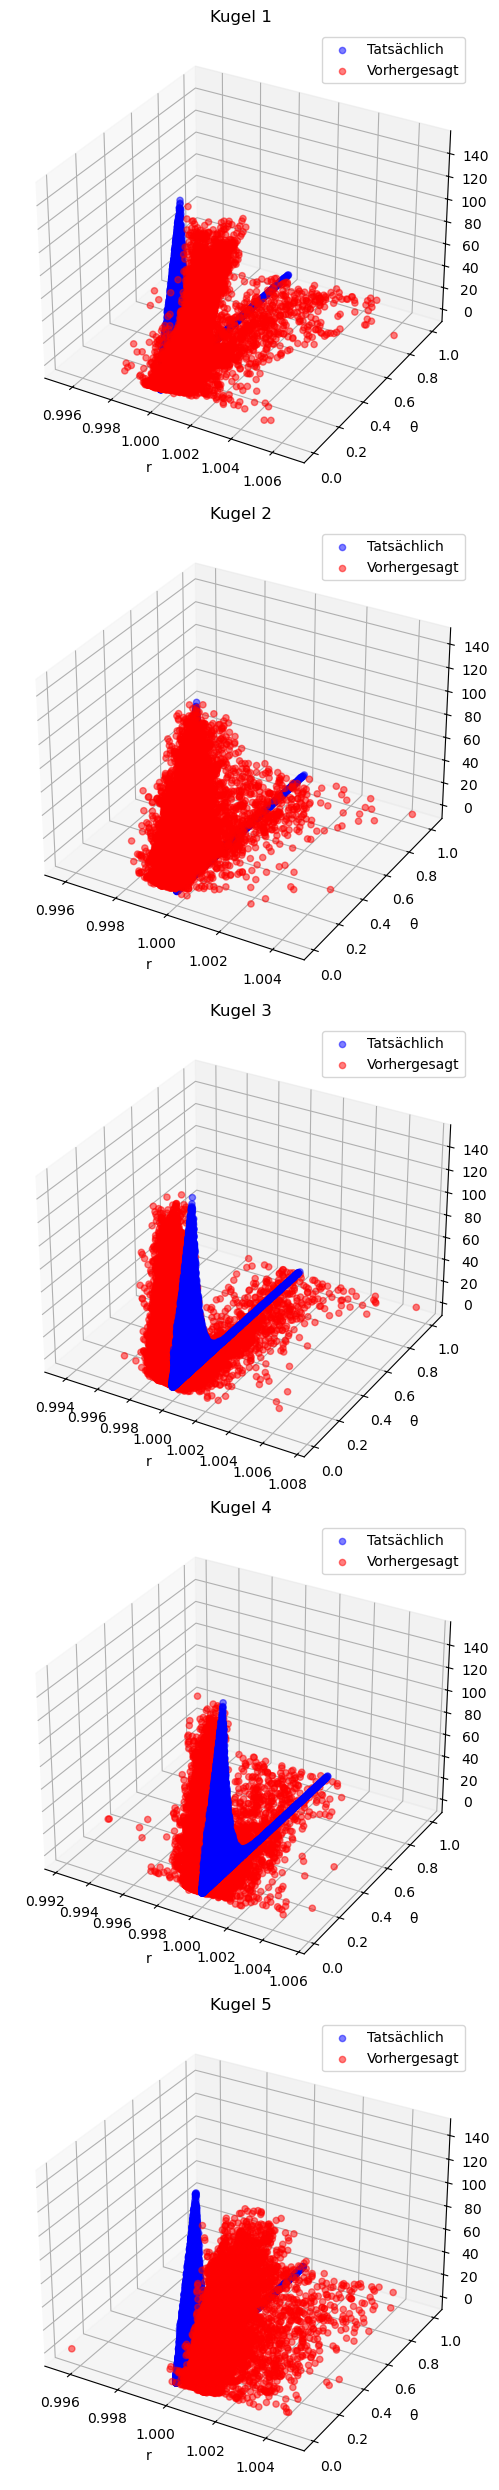

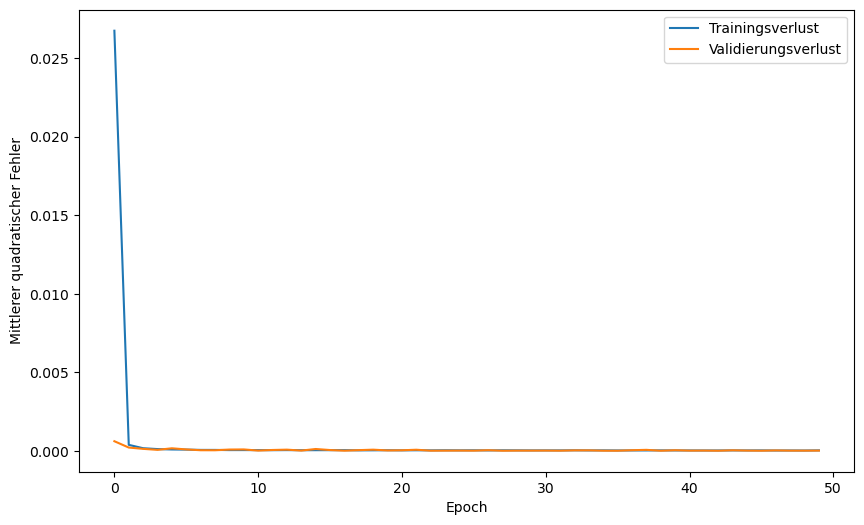

Kugel 1 - MSE: r=0.0000, θ=0.0000, φ=0.0125
Kugel 2 - MSE: r=0.0000, θ=0.0000, φ=0.0244
Kugel 3 - MSE: r=0.0000, θ=0.0000, φ=0.0170
Kugel 4 - MSE: r=0.0000, θ=0.0000, φ=0.0342
Kugel 5 - MSE: r=0.0000, θ=0.0000, φ=0.0190


In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Konstanten
g = 9.81  # Erdbeschleunigung in m/s^2
l = 1.0   # Pendellänge in m
m = 0.1   # Masse einer Kugel in 
kg
n_balls = 5  # Anzahl der Kugeln

def newton_pendulum_ode(y, t, g, l, m, n):
    """Differentialgleichungen für n Kugeln des Newtonschen Pendels"""
    dy = np.zeros_like(y)
    for i in range(n):
        theta, phi, omega_theta, omega_phi = y[4*i:4*i+4]
        

        dy[4*i] = omega_theta
        dy[4*i+1] = omega_phi
        dy[4*i+2] = -(g / l) * np.sin(theta) - 2 * omega_theta * omega_phi * np.cos(theta) / np.sin(theta)
        dy[4*i+3] = -2 * omega_theta * omega_phi / np.tan(theta)
        
    
    return dy

def generate_newton_pendulum_data(n_samples, t_max, dt, n_balls):
    t = np.arange(0, t_max, dt)
    data = []
    
    for _ in range(n_samples):
        initial_state = np.random.rand(4 * n_balls)  # Zufällige Anfangsbedingungen
        solution = odeint(newton_pendulum_ode, initial_state, t, args=(g, l, m, n_balls))
        
        spherical_coords = []
        for i in range(n_balls):
            theta, phi = solution[:, 4*i], solution[:, 4*i+1]
            r = l * np.ones_like(theta)  # Konstanter Radius
            spherical_coords.append(np.column_stack((r, theta, phi)))
        
        data.append(np.column_stack((t, np.hstack(spherical_coords))))
    
    return np.vstack(data)

# Daten generieren
n_samples = 1000
t_max = 10.0
dt = 0.1
data = generate_newton_pendulum_data(n_samples, t_max, dt, n_balls)

# Daten vorbereiten
X = data[:, :1 + 3 * n_balls]  # Zeit und 3 vorherige Positionen als Features
y = data[:, 1:1 + 3 * n_balls]  # Nächste Position als Ziel
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Daten normalisieren
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

# Daten für LSTM umformen
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# LSTM Modell definieren
model = Sequential([
    LSTM(100, activation='relu', input_shape=(1, 1 + 3 * n_balls)),
    Dense(3 * n_balls)
])
model.compile(optimizer='adam', loss='mse')

# Modell trainieren
history = model.fit(X_train_reshaped, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Vorhersagen machen
y_pred_scaled = model.predict(X_test_reshaped)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Funktion zur Visualisierung der Ergebnisse
def plot_spherical_predictions(y_true, y_pred, n_balls):
    fig = plt.figure(figsize=(15, 5 * n_balls))
    for i in range(n_balls):
        ax = fig.add_subplot(n_balls, 3, 3*i+1, projection='3d')
        ax.scatter(y_true[:, 3*i], y_true[:, 3*i+1], y_true[:, 3*i+2], c='b', label='Tatsächlich', alpha=0.5)
        ax.scatter(y_pred[:, 3*i], y_pred[:, 3*i+1], y_pred[:, 3*i+2], c='r', label='Vorhergesagt', alpha=0.5)
        ax.set_title(f'Kugel {i+1}')
        ax.set_xlabel('r')
        ax.set_ylabel('θ')
        ax.set_zlabel('φ')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Ergebnisse visualisieren
plot_spherical_predictions(y_test, y_pred, n_balls)

# Trainings- und Validierungsverlust plotten
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Trainingsverlust')
plt.plot(history.history['val_loss'], label='Validierungsverlust')
plt.xlabel('Epoch')
plt.ylabel('Mittlerer quadratischer Fehler')
plt.legend()
plt.show()

# Mittlerer quadratischer Fehler berechnen
mse = np.mean((y_test - y_pred)**2, axis=0)
for i in range(n_balls):
    print(f"Kugel {i+1} - MSE: r={mse[3*i]:.4f}, θ={mse[3*i+1]:.4f}, φ={mse[3*i+2]:.4f}")

In [2]:
pip install numpy pandas scipy scikit-learn tensorflow matplotlib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import tensorflow as tf

# Seed setting
np.random.seed(42)
tf.random.set_seed(42)

# Konstanten
g = 9.81  # Erdbeschleunigung in m/s^2
l = 1.0   # Pendellänge in m
m = 0.1   # Masse einer Kugel in kg
n_balls = 5  # Anzahl der Kugeln

def newton_pendulum_ode(y, t, g, l, m, n):
    """Differentialgleichungen für n Kugeln des Newtonschen Pendels"""
    dy = np.zeros_like(y)
    for i in range(n):
        theta, phi, omega_theta, omega_phi = y[4*i:4*i+4]
        
        # Vereinfachte Gleichungen für jede Kugel (ohne Kollisionen)
        dy[4*i] = omega_theta
        dy[4*i+1] = omega_phi
        dy[4*i+2] = -(g / l) * np.sin(theta) - 2 * omega_theta * omega_phi * np.cos(theta) / np.sin(theta)
        dy[4*i+3] = -2 * omega_theta * omega_phi / np.tan(theta)
        
        # Hier müssten komplexere Kollisionsberechnungen implementiert werden
    
    return dy

def generate_newton_pendulum_data(n_samples, t_max, dt, n_balls):
    """Generiert Trainingsdaten für das Newtonsche Pendel"""
    t = np.arange(0, t_max, dt)
    data = []
    
    for _ in range(n_samples):
        initial_state = np.random.rand(4 * n_balls)  # Zufällige Anfangsbedingungen
        solution = odeint(newton_pendulum_ode, initial_state, t, args=(g, l, m, n_balls))
        
        spherical_coords = []
        for i in range(n_balls):
            theta, phi = solution[:, 4*i], solution[:, 4*i+1]
            r = l * np.ones_like(theta)  # Konstanter Radius
            spherical_coords.append(np.column_stack((r, theta, phi)))
        
        data.append(np.column_stack((t, np.hstack(spherical_coords))))
    
    return np.vstack(data)

# Daten generieren
n_samples = 1000
t_max = 10.0
dt = 0.1
data = generate_newton_pendulum_data(n_samples, t_max, dt, n_balls)

# Daten vorbereiten
X = data[:, :1 + 3 * n_balls]  # Zeit und 3 vorherige Positionen als Features
y = data[:, 1:1 + 3 * n_balls]  # Nächste Position als Ziel
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Daten normalisieren
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

# Daten für LSTM umformen
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# LSTM Modell definieren
model = Sequential([
    LSTM(100, activation='relu', input_shape=(1, 1 + 3 * n_balls)),
    Dense(3 * n_balls)
])
model.compile(optimizer='adam', loss='mse')

# Modell trainieren
history = model.fit(X_train_reshaped, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Vorhersagen machen
y_pred_scaled = model.predict(X_test_reshaped)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Funktion zur Visualisierung der Ergebnisse
def plot_spherical_predictions(y_true, y_pred, n_balls):
    fig = plt.figure(figsize=(15, 5 * n_balls))
    for i in range(n_balls):
        ax = fig.add_subplot(n_balls, 3, 3*i+1, projection='3d')
        ax.scatter(y_true[:, 3*i], y_true[:, 3*i+1], y_true[:, 3*i+2], c='b', label='Tatsächlich', alpha=0.5)
        ax.scatter(y_pred[:, 3*i], y_pred[:, 3*i+1], y_pred[:, 3*i+2], c='r', label='Vorhergesagt', alpha=0.5)
        ax.set_title(f'Kugel {i+1}')
        ax.set_xlabel('r')
        ax.set_ylabel('θ')
        ax.set_zlabel('φ')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Ergebnisse visualisieren
plot_spherical_predictions(y_test, y_pred, n_balls)

# Trainings- und Validierungsverlust plotten
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Trainingsverlust')
plt.plot(history.history['val_loss'], label='Validierungsverlust')
plt.xlabel('Epoch')
plt.ylabel('Mittlerer quadratischer Fehler')
plt.legend()
plt.show()

# Mittlerer quadratischer Fehler berechnen
mse = np.mean((y_test - y_pred)**2, axis=0)
for i in range(n_balls):
    print(f"Kugel {i+1} - MSE: r={mse[3*i]:.4f}, θ={mse[3*i+1]:.4f}, φ={mse[3*i+2]:.4f}")

C:\Users\mnnia\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.1006 - val_loss: 7.4622e-04
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 5.3335e-04 - val_loss: 2.6129e-04
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 2.1095e-04 - val_loss: 1.2698e-04
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.2705e-04 - val_loss: 9.4487e-05
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 9.5871e-05 - val_loss: 7.5948e-05
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 8.5393e-05 - val_loss: 6.7085e-05
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 7.8008e-05 - val_loss: 6.4630e-05
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 7.0269e-05 - val_loss: 6.5489e-05
Epoch 9/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 6.3991e-05 - val_loss: 6.1806e-05
Epoch 10/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 5.5989e-05 - val_loss: 5.4924e-05
Epoch 11/50
2000/2000 ━━━━━━━━━━━━